In [1]:
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(vegan)
library(plyr)
library(RColorBrewer)
library(stats)
library(dplyr)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: iterators

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattic

In [3]:
%%R
physeq = import_biom("data/otu_table_wtax.biom")
print(physeq)
sample.data = import_qiime_sample_data("data/Metadata_fungi.txt")
physeq = merge_phyloseq(physeq,sample.data)
print(physeq)
physeq.md = sample_data(physeq)
physeq.fungi = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS"))& 
                             (physeq.md$SampleID != c("D312.6")),  physeq)
physeq.fungi.prune = prune_samples(sample_sums(physeq.fungi) > 5360, physeq.fungi)
print (physeq.fungi.prune)
physeq.fungi.snorm = transform_sample_counts(physeq.fungi.prune, function(x) x/sum(x))
physeq.fungi.thresh = filter_taxa(physeq.fungi.snorm, function(x) sum(x > 0) / length(x) > (0.25), TRUE)
#physeq.fungi.thresh.min = filter_taxa(physeq.fungi.thresh, function(x) sum(x) > 5000, TRUE)
#physeq.fungi.thresh = filter_taxa(physeq.SIP.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.fungi.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 173 samples ]
sample_data() Sample Data:       [ 173 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2032 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2032 taxa by 7 taxonomic ranks ]
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 600 taxa and 162 samples ]
sample_data() Sample Data:       [ 162 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 600 taxa by 7 taxonomic ranks ]


In [4]:
%%R
df = psmelt(physeq.fungi.thresh)

In [5]:
%%R
df.OTU = df %>%
    group_by(OTU) %>%
    select(OTU, Abundance, Density)
    
    

In [6]:
%%R
df.l2fc = read.csv("data/l2fc_UNITE.csv", header = TRUE, sep = ",")
head(df.l2fc)

  Day    OTU log2FoldChange     lfcSE    Rank1      Rank2           Rank3
1   3 OTU.40     -1.7995959 0.3482440 k__Fungi Ascomycota Sordariomycetes
2   3  OTU.7      2.7460387 0.4049920 k__Fungi Ascomycota Sordariomycetes
3   3  OTU.5     -0.3195079 0.5060621 k__Fungi Ascomycota Sordariomycetes
4   3  OTU.3     -0.3862363 0.3147093 k__Fungi Ascomycota Sordariomycetes
5   3 OTU.16      0.4177197 0.2757979 k__Fungi Ascomycota            <NA>
6   3 OTU.11     -1.5514248 0.3555538 k__Fungi Ascomycota Sordariomycetes
           Rank4                Rank5        Rank6                Rank7 RNA_DNA
1    Hypocreales          Nectriaceae     Fusarium                 <NA>     DNA
2    Sordariales        Chaetomiaceae   Chaetomium  Chaetomium_globosum     DNA
3    Sordariales        Chaetomiaceae     Humicola                 <NA>     DNA
4 Incertae_sedis Plectosphaerellaceae         <NA>                 <NA>     DNA
5           <NA>                 <NA>         <NA>                 <NA>     DNA
6 

In [114]:
%%R
df.nonresp = filter(df.l2fc, padj >= 0.10)
head(df.nonresp)

  Day    OTU log2FoldChange     lfcSE    Rank1      Rank2           Rank3
1   3 OTU.40     -1.7995959 0.3482440 k__Fungi Ascomycota Sordariomycetes
2   3  OTU.7      2.7460387 0.4049920 k__Fungi Ascomycota Sordariomycetes
3   3  OTU.5     -0.3195079 0.5060621 k__Fungi Ascomycota Sordariomycetes
4   3  OTU.3     -0.3862363 0.3147093 k__Fungi Ascomycota Sordariomycetes
5   3 OTU.16      0.4177197 0.2757979 k__Fungi Ascomycota            <NA>
6   3 OTU.11     -1.5514248 0.3555538 k__Fungi Ascomycota Sordariomycetes
           Rank4                Rank5        Rank6                Rank7 RNA_DNA
1    Hypocreales          Nectriaceae     Fusarium                 <NA>     DNA
2    Sordariales        Chaetomiaceae   Chaetomium  Chaetomium_globosum     DNA
3    Sordariales        Chaetomiaceae     Humicola                 <NA>     DNA
4 Incertae_sedis Plectosphaerellaceae         <NA>                 <NA>     DNA
5           <NA>                 <NA>         <NA>                 <NA>     DNA
6 

In [7]:
%%R
df.resp = filter(df.l2fc, padj <= 0.10)
length(df.resp$OTU)

[1] 128


In [18]:
%%R
df %>%
group_by(OTU, Day, Treatment) %>%
summarise(ab = sum(Abundance))

Source: local data frame [4,800 x 4]
Groups: OTU, Day [?]

      OTU   Day Treatment        ab
    (chr) (int)    (fctr)     (dbl)
1   OTU.1     3    12CCPS 0.2720528
2   OTU.1     3    13CCPS 1.4093096
3   OTU.1     7    12CCPS 1.6606546
4   OTU.1     7    13CCPS 2.4451200
5   OTU.1    14    12CCPS 3.1717361
6   OTU.1    14    13CCPS 4.2457220
7   OTU.1    30    12CCPS 3.0701509
8   OTU.1    30    13CCPS 2.0532887
9  OTU.10     3    12CCPS 0.7894008
10 OTU.10     3    13CCPS 0.7942653
..    ...   ...       ...       ...


In [19]:
%%R
a = arrange(df.resp, desc(log2FoldChange)) %>%
group_by(OTU) %>%
summarise(daysum = sum(Day)) %>%
filter(daysum != c(3,7,14,30)) %>%
arrange(desc(daysum))

In [21]:
%%R
a

Source: local data frame [77 x 2]

         OTU daysum
      (fctr)  (int)
1  OTU.10703     51
2   OTU.1440     51
3  OTU.18463     51
4   OTU.2502     51
5  OTU.27052     51
6    OTU.494     51
7    OTU.606     51
8   OTU.1216     44
9  OTU.13836     44
10 OTU.14370     44
..       ...    ...


In [36]:
%%R
consec = filter(a, daysum >= 21)

In [37]:
%%R
length(consec$OTU)

[1] 38


In [38]:
%%R
df.r = filter(df, OTU %in% consec$OTU)
df.r = select(df.r, Abundance, Density, Treatment, Day, OTU)

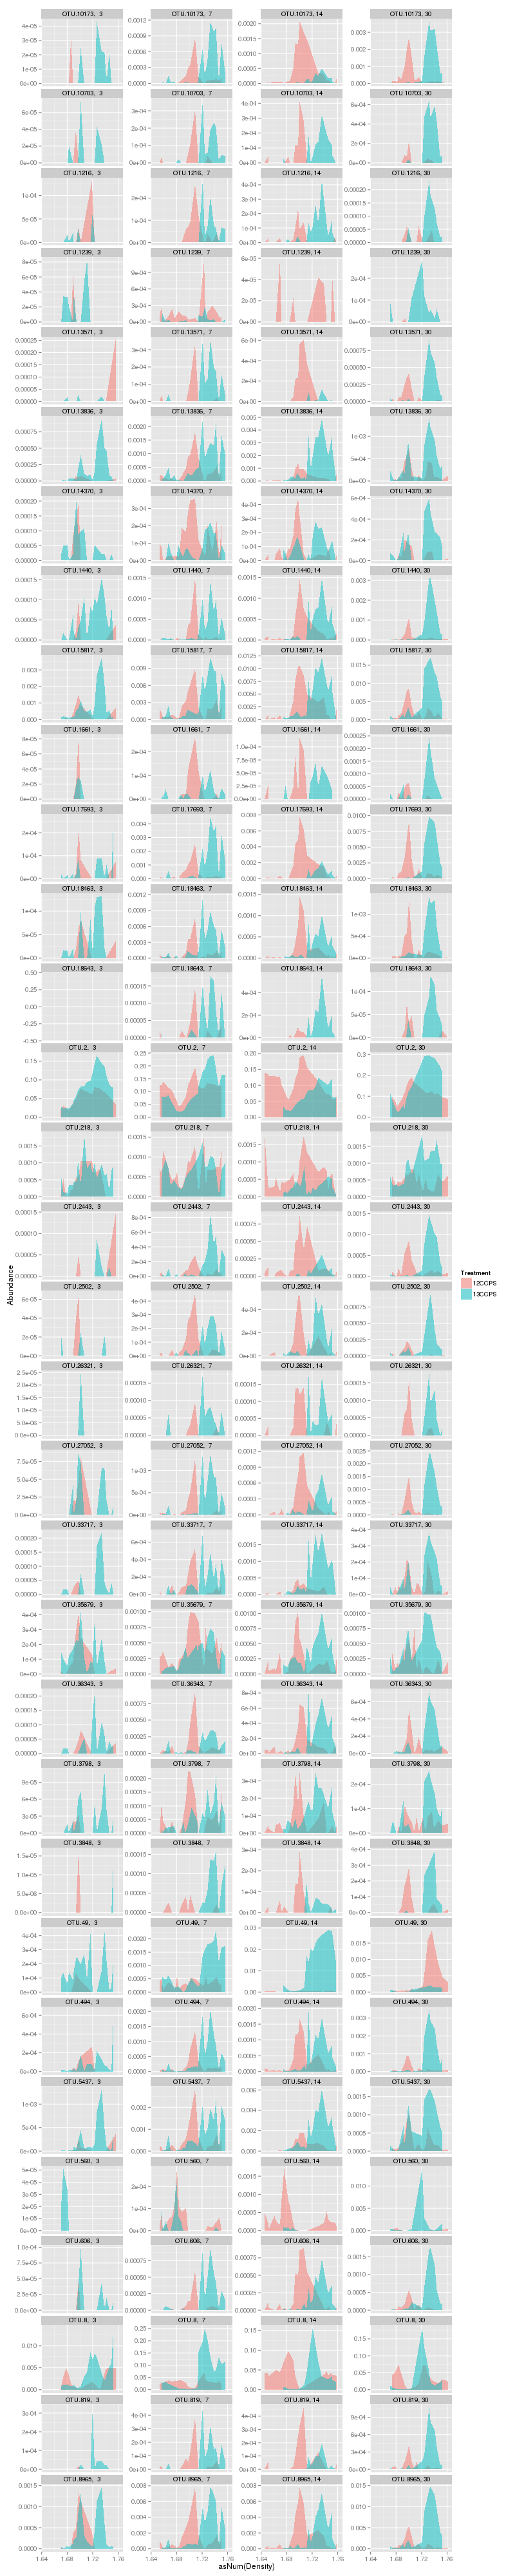

In [40]:
%%R -w 800 -h 4000
asNum = function(x) { as.numeric(as.character(x)) }
#otu.id = "OTU.758"
p = ggplot(df.r, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~OTU + Day, ncol = 4, scales = "free_y")
print(p)

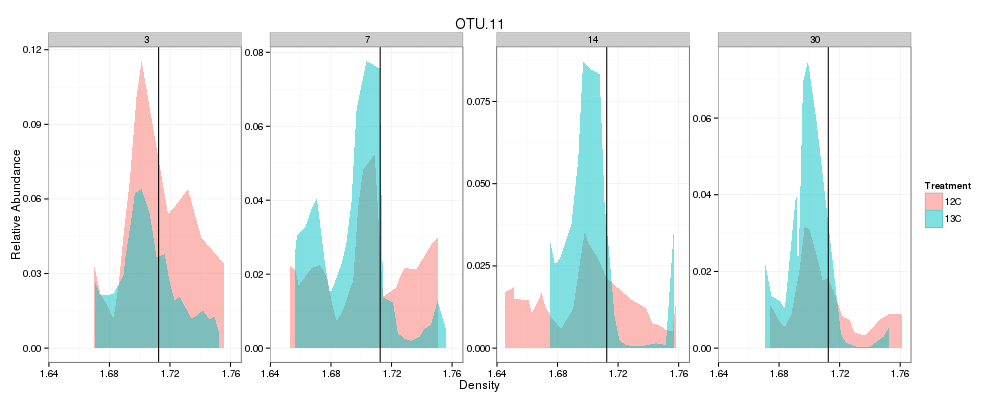

In [173]:
%%R -w 1000 -h 400
rOTU = "OTU.11"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(OTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

In [174]:
%%R
ggsave(filename = "data/figs/density_ab_OTU11.pdf", plot = p, width = 10, height = 4)

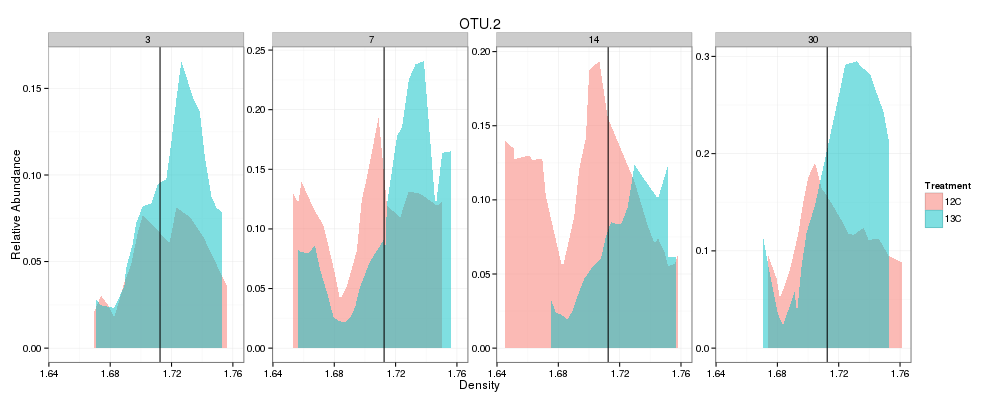

In [175]:
%%R -w 1000 -h 400
rOTU = "OTU.2"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(rOTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

In [176]:
%%R
ggsave(filename = "data/figs/density_ab_OTU2.pdf", plot = p, width = 10, height = 4)

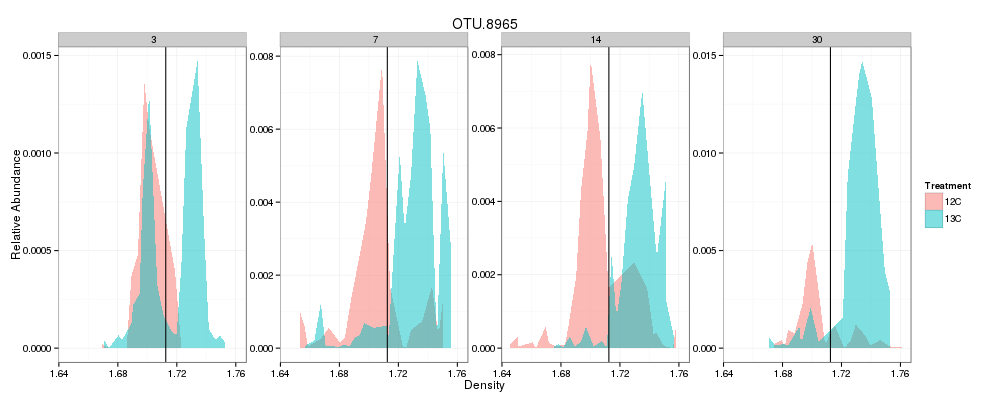

In [177]:
%%R -w 1000 -h 400
rOTU = "OTU.8965"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(rOTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

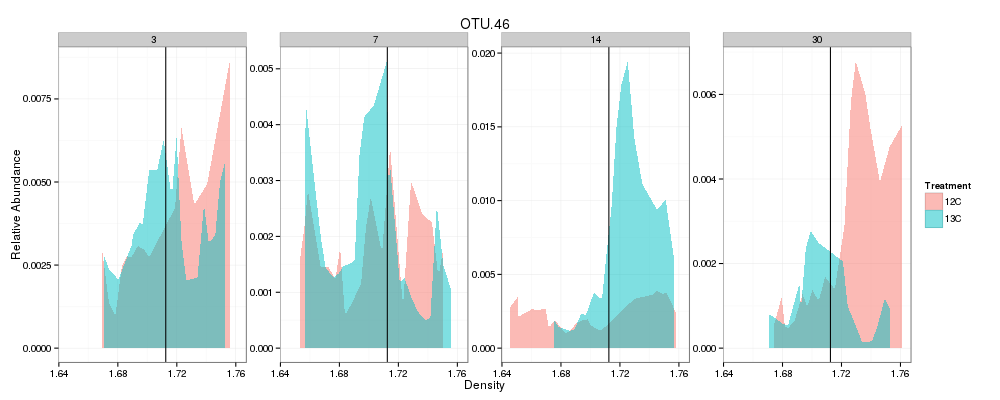

In [180]:
%%R -w 1000 -h 400
rOTU = "OTU.46"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(rOTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

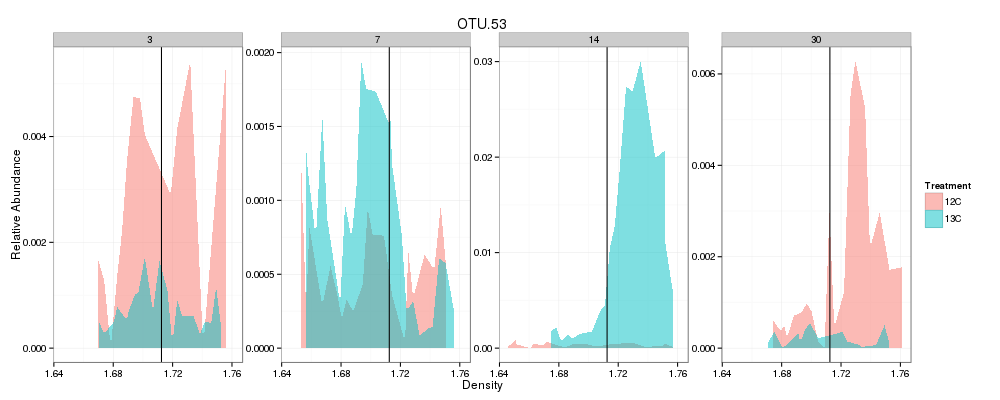

In [181]:
%%R -w 1000 -h 400
rOTU = "OTU.53"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(rOTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

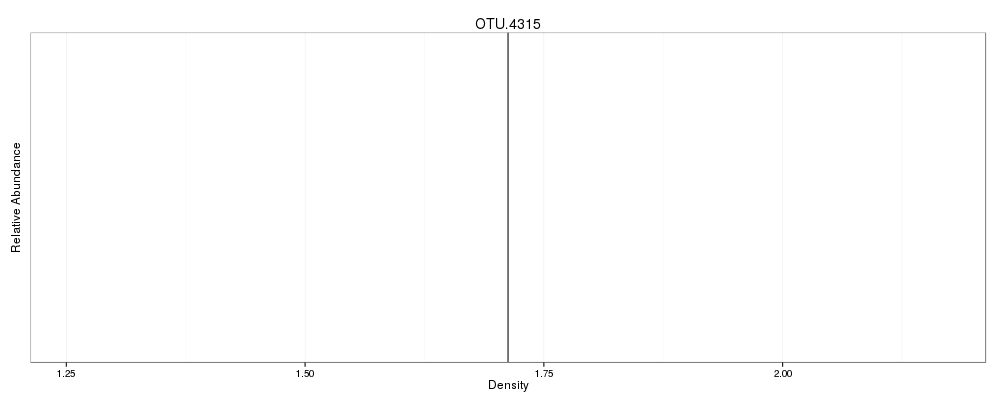

In [184]:
%%R -w 1000 -h 400
rOTU = "OTU.4315"
df.OTU= filter(df, OTU == rOTU)
p = ggplot(df.OTU, aes(x = asNum(Density), y = Abundance))
p = p + geom_area(aes(fill = Treatment), position = "dodge", alpha = 0.5)
#p = p + facet_wrap(~Day, ncol = 4, scales = "free_y") 
p = p + ggtitle(rOTU) + xlab("Density") + ylab("Relative Abundance") + scale_fill_discrete(labels = c("12C", "13C"))
p = p + theme(text = element_text(size=18)) + geom_vline(xintercept = 1.7125) + theme_bw()
print(p)

In [179]:
%%R
hypo = filter(df.l2fc, Rank4 == "Hypocreales", padj <=0.10)
hypo

  Day      OTU log2FoldChange     lfcSE    Rank1      Rank2           Rank3
1  14   OTU.46       4.574239 0.4182736 k__Fungi Ascomycota Sordariomycetes
2  14   OTU.53       8.872466 0.6225278 k__Fungi Ascomycota Sordariomycetes
3  14 OTU.4315       6.852980 1.7876729 k__Fungi Ascomycota Sordariomycetes
        Rank4           Rank5      Rank6                   Rank7 RNA_DNA
1 Hypocreales Clavicipitaceae   Pochonia Pochonia_chlamydosporia     DNA
2 Hypocreales  Incertae_sedis Acremonium                    <NA>     DNA
3 Hypocreales Clavicipitaceae   Pochonia Pochonia_chlamydosporia     DNA
  sparsity            p         padj
1     1.00 2.706151e-08 1.969245e-06
2     0.90 2.339784e-26 1.475624e-23
3     0.25 5.434616e-03 8.096294e-02


In [178]:
%%R
ggsave(filename = "data/figs/density_ab_OTU8965.pdf", plot = p, width = 10, height = 4)

In [ ]:
##Figure with density of bacterial vs fungal delta BD

In [30]:
import pandas as pd
import pandas.rpy.common as com
import numpy as np

/opt/anaconda/lib/python2.7/site-packages/pandas/rpy/__init__.py:11: FutureWarning: The pandas.rpy module is deprecated and will be removed in a future version. We refer to external packages like rpy2. 
See here for a guide on how to port your code to rpy2: http://pandas.pydata.org/pandas-docs/stable/r_interface.html
  FutureWarning)


In [43]:
%%R
physeq.bac = import_biom("/home/ashley/succ-C-DNASIP/data/otu_table_wtax.biom", "/home/ashley/data/otusn.tree")
sample.data = import_qiime_sample_data("/home/ashley/succ-C-DNASIP/data/ABCD_combined_reads_mapper.tsv")
physeq.bac = merge_phyloseq(physeq.bac,sample.data)
physeq.bac.md = sample_data(physeq.bac)
#filtering out bulk and normalizing by total sample count
physeq.PS = prune_samples((physeq.bac.md$Treatment %in% c("12CCPS","13CCPS","13CXPS"))&
                          !(row.names(physeq.bac.md) %in% grep("bulk", row.names(physeq.bac.md), value=TRUE)), physeq.bac)
physeq.PS = transform_sample_counts(physeq.PS, function(x) x/sum(x))

In [44]:
%%R
df.bac = psmelt(physeq.PS)

In [75]:
%%R
df.bac$treat[df.bac$Treatment == "13CCPS"] = "13CCPS_B"
df.bac$treat[df.bac$Treatment == "12CCPS"] = "12CCPS"

In [78]:
%%R
df.bac2 = select(df.bac, OTU, Sample, Abundance, Day, Density, treat) %>%
          filter(treat %in% c("12CCPS", "13CCPS_B"))
head(df.bac2)

    OTU        Sample Abundance Day Density    treat
1 OTU.6  13C.PS.14.10 0.3324195  14  1.7297 13CCPS_B
2 OTU.6   13C.PS.14.9 0.2913640  14  1.7351 13CCPS_B
3 OTU.6  13C.PS.14.11 0.2356148  14  1.7253 13CCPS_B
4 OTU.1 cont.PS.30.10 0.2277195  30  1.7362   12CCPS
5 OTU.6   13C.PS.7.12 0.2268133   7  1.7330 13CCPS_B
6 OTU.1   cont.PS.3.7 0.2194170   3  1.7450   12CCPS


In [79]:
%%R
length(df.bac2$OTU)

[1] 1122480


In [80]:
%%R
df2 = df
df.2$treat[df.2$Treatment == "13CCPS"] = "13CCPS_F"
df.2$treat[df.2$Treatment == "12CCPS"] = "12CCPS"

In [82]:
%%R
df.2 = select(df.2, OTU, Sample, Abundance, Day, Density, treat) %>%
          filter(treat %in% c("12CCPS", "13CCPS_F"))
head(df.2)

    OTU   Sample Abundance Day  Density    treat
1 OTU.1  D1413.6 0.4184204  14 1.751536 13CCPS_F
2 OTU.1  D1413.7 0.3972463  14 1.744979 13CCPS_F
3 OTU.1  D1413.8 0.3724805  14 1.751536 13CCPS_F
4 OTU.1  D1413.9 0.3598390  14 1.735145 13CCPS_F
5 OTU.1 D1413.10 0.3580522  14 1.729681 13CCPS_F
6 OTU.1 D1413.11 0.3521933  14 1.725310 13CCPS_F


In [83]:
%%R
length(df.2$OTU)

[1] 97200


In [84]:
%%R
d.total = rbind(df.2, df.bac2)

In [85]:
%%R
length(d.total$OTU)

[1] 1219680


In [31]:
%%R
sample.data = sample_data(physeq.fungi.thresh)
asNum = function(x) as.numeric(as.character(x))
sample.data$Density = asNum(sample.data$Density)
sample.data$Day = asNum(sample.data$Day)
sample.data$Treatment = as.character(sample.data$Treatment)
sample.data = sample.data[,c("Day","Treatment","Density")]
aggdata.min = aggregate(sample.data, by = list(sample.data$Treatment, sample.data$Day), FUN = min, na.rm = TRUE)
aggdata.max = aggregate(sample.data, by = list(sample.data$Treatment, sample.data$Day), FUN = max, na.rm = TRUE)
minmax = max(aggdata.min$Density)
maxmin = min(aggdata.max$Density)

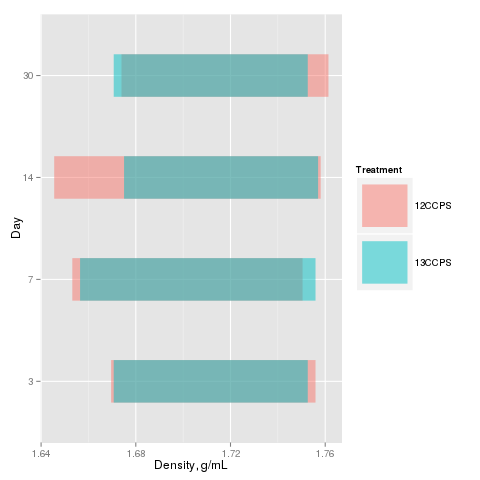

In [32]:
%%R
aggdata.minmax = ddply(sample.data, .(Day, Treatment), summarize, min = min(Density), max = max(Density))
#print(aggdata.minmax)
p = ggplot(aggdata.minmax) 
p = p + geom_segment(aes(y = factor(Day), yend = factor(Day), 
                         x = min, xend = max,
                         color = Treatment), size = I(20), alpha = 0.5,
                         data = subset(aggdata.minmax, Treatment %in% c("12CCPS", "13CCPS")))

p = p + ylab("Day") + xlab("Density, g/mL")

p

In [33]:
maxmin = %Rget maxmin
minmax = %Rget minmax
maxmin = maxmin[0]
minmax = minmax[0]
print maxmin, minmax

1.75044316 1.67504272


In [86]:
mdf = com.load_data("d.total")
mdf["Density"] = mdf["Density"].astype(float)
mdf.reset_index(inplace=True)

In [87]:
mdf.head()

,index,OTU,Sample,Abundance,Day,Density,treat
0,1,OTU.1,D1413.6,0.418420,14,1.751536,13CCPS_F
1,2,OTU.1,D1413.7,0.397246,14,1.744979,13CCPS_F
2,3,OTU.1,D1413.8,0.372481,14,1.751536,13CCPS_F
3,4,OTU.1,D1413.9,0.359839,14,1.735145,13CCPS_F
4,5,OTU.1,D1413.10,0.358052,14,1.729681,13CCPS_F


In [88]:
def wavg(group, r = (minmax, maxmin), N=20):
    day, = set(group.Day) #should only be one day in each group
    g_sorted = group.sort("Density", ascending=True)
    d = g_sorted["Density"]
    w = g_sorted["Abundance"]
    x = np.linspace(r[0],r[1],N)
    yinterp = np.interp(x, d, w)
    return (x*yinterp).sum()/yinterp.sum()

In [92]:
mdf_grouped = mdf.groupby(("Day","treat","OTU"))
OTU_wavg = mdf_grouped.apply(wavg)

In [93]:
OTU_wavg_df = OTU_wavg.reset_index()
OTU_wavg_df.rename(columns={0:"density_wavg"}, inplace=True)
OTU_wavg_df.head()

,Day,treat,OTU,density_wavg
0,1,12CCPS,OTU.1,1.718240
1,1,12CCPS,OTU.10,1.717668
2,1,12CCPS,OTU.100,1.712736
3,1,12CCPS,OTU.1000,1.709901
4,1,12CCPS,OTU.1001,1.731957


In [100]:
l = []
for t in ["13CCPS_F", "13CCPS_B"]:
    df_t = OTU_wavg_df[(OTU_wavg_df["treat"]==t)|(OTU_wavg_df["treat"]=="12CCPS")]
    df_t_pivot = pd.pivot_table(df_t, 
                           values="density_wavg", 
                           index="OTU", 
                           columns=["Day", "treat"])
    g = df_t_pivot.groupby(level=0, axis=1)
    for k in g.groups:
        d = g.get_group(k)
        try:
            d["shift"] = d[(k, t)] - d[(k, "12CCPS")]
        except KeyError:
            continue
        df = pd.DataFrame.from_dict(d["shift"].to_dict(), orient="index")
        df.rename(columns={0 : "shift"}, inplace=True)
        df["Day"] = [k for i in df.index]
        df["treat"] = [t for i in df.index]
        l.append(df)
df_shift = pd.concat(l)
df_shift = df_shift.reset_index()
df_shift.rename(columns={"index" : "OTU"}, inplace=True)
df_shift.head()


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,OTU,shift,Day,treat
0,OTU.759,0.026147,3,13CCPS_F
1,OTU.758,0.015151,3,13CCPS_F
2,OTU.757,NaN,3,13CCPS_F
3,OTU.756,-0.009331,3,13CCPS_F
4,OTU.5419,NaN,3,13CCPS_F


In [101]:
df_shiftR = com.convert_to_r_dataframe(df_shift, strings_as_factors=True)
%Rpush df_shiftR

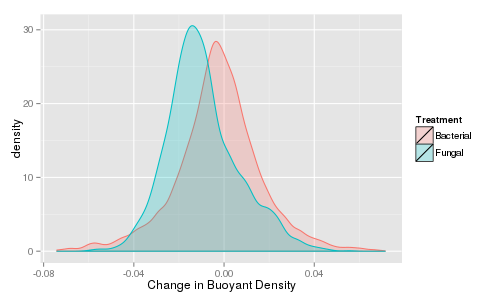

In [112]:
%%R -w 500 -h 300
p = ggplot(df_shiftR, aes(x = shift, color = treat, fill = treat))

p = p + geom_density(alpha = 0.25)

p = p + xlab("Change in Buoyant Density") + scale_fill_discrete(name = "Treatment", labels = c("Bacterial", "Fungal")) 

p = p + guides(color=FALSE)

p

In [113]:
%%R
ggsave(filename = "data/figs/fungal_bac_densityshift.pdf", plot = p, width = 6, height = 4)